## Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [3]:
%%R
workDir = '/home/chantal/Chazy/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

##Import R libraries we'll use.

In [4]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr) ;library(dplyr)
library(RColorBrewer)
library(stats)
library(ape)
library(stringr)
library(ade4)
library(reshape2)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

## Import data into R. Prune to relevant samples (Chazy). Get rid of OTUs not observed in at least 25% of samples)

In [5]:
%%R

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE)
#physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk.core = prune_samples(physeq.Bulk.m$Land_Management != "PAS", physeq.Bulk)

physeq.Bulk.m = physeq.Bulk.core %>% sample_data
    

physeq.Bulk.core = physeq.Bulk.core %>% transform_sample_counts(function(x) x/sum(x))

physeq.Bulk.m = physeq.Bulk.core %>% sample_data

#print(physeq.Bulk.Sparsity)
print(physeq.Bulk.core)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


### Calculate Unifrac distances between samples.

In [6]:
%%R
method = 'bray'

In [7]:
%%R
registerDoParallel(cores=20)
wunif.dist.nopas = phyloseq::distance(physeq.Bulk.core, 
                      method = method)

In [8]:
%%R
physeq.Bulk.core


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [9]:
%%R
# Removing samples w/o soil temperature

physeq.Bulk.m = physeq.Bulk.core %>% sample_data

physeq.notemp = prune_samples(!(is.na(physeq.Bulk.m$Soil_Temp)), physeq.Bulk.core)

physeq.notemp 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 128 samples ]
sample_data() Sample Data:       [ 128 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [10]:
%%R
registerDoParallel(cores=20)
wunif.dist.notemp = phyloseq::distance(physeq.notemp, 
                      method = method)

In [11]:
%%R
# Removing samples w/o soil moisture
physeq.Bulk.m = physeq.Bulk.core %>% sample_data

physeq.nomoist = prune_samples(!(is.na(physeq.Bulk.m$Soil_Moisture)), physeq.Bulk.core)

physeq.nomoist

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 160 samples ]
sample_data() Sample Data:       [ 160 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [12]:
%%R
registerDoParallel(cores=20)
wunif.dist.nomoist = phyloseq::distance(physeq.nomoist, 
                      method = method)

## Distance vs Time

In [13]:
%%R
library(reshape2)

df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))

In [14]:
%%R
head(df)


              T1          T2     value
1    April.NTR.4 April.NTR.4 0.0000000
2 Aug.NTR.3.2015 April.NTR.4 0.4997069
3    April.PTR.3 April.NTR.4 0.6171277
4   July15.NTH.3 April.NTR.4 0.5200756
5      Nov.NTR.1 April.NTR.4 0.7084343
6     June.NTH.2 April.NTR.4 0.5763744


In [15]:
%%R
physeq.test = sample_data(physeq.Bulk.core)

physeq.test = plyr::rename(physeq.test, c("Full.sample"="T1", "Sample_Date"="SD_T1"))

head(physeq.test)

Sample Data:        [6 samples by 24 sample variables]:
                           T1 Fraction PrimerF PrimerR Barcode Rev.index
April.NTR.4       April.NTR.4       NA  nBITSf   58A2r     155  atagtacc
Aug.NTR.3.2015 Aug.NTR.3.2015       NA  nBITSf   58A2r     129  gatctacg
April.PTR.3       April.PTR.3       NA  nBITSf   58A2r     150  acgtgcgc
July15.NTH.3     July15.NTH.3       NA  nBITSf   58A2r     184  aacgctga
Nov.NTR.1           Nov.NTR.1       NA  nBITSf   58A2r     125  tctctatg
June.NTH.2         June.NTH.2       NA  nBITSf   58A2r     162  gcgtatac
               Fwd.index Treatment Day Pool     Experiment Gradient
April.NTR.4     tagcgagt       NTR  NA    4 Chazy.ITS.Bulk     <NA>
Aug.NTR.3.2015  atcgtacg       NTR  NA    5 Chazy.ITS.Bulk     <NA>
April.PTR.3     cgtgagtg       PTR  NA    4 Chazy.ITS.Bulk     <NA>
July15.NTH.3    gacaccgt       NTH  NA    4 Chazy.ITS.Bulk     <NA>
Nov.NTR.1       tcatcgag       NTR  NA    4 Chazy.ITS.Bulk     <NA>
June.NTH.2      actatctg 

In [16]:
%%R

Test = full_join(df, physeq.test, by = 'T1')

In [17]:
%%R

physeq.test2 = plyr::rename(physeq.test, c("T1"="T2", "SD_T1"="SD_T2"))


In [18]:
%%R
Test2 = full_join(Test, physeq.test2, by = 'T2')
print(head(Test))
print(length(Test2$T2))

              T1          T2     value Fraction PrimerF PrimerR Barcode
1    April.NTR.4 April.NTR.4 0.0000000       NA  nBITSf   58A2r     155
2 Aug.NTR.3.2015 April.NTR.4 0.4997069       NA  nBITSf   58A2r     129
3    April.PTR.3 April.NTR.4 0.6171277       NA  nBITSf   58A2r     150
4   July15.NTH.3 April.NTR.4 0.5200756       NA  nBITSf   58A2r     184
5      Nov.NTR.1 April.NTR.4 0.7084343       NA  nBITSf   58A2r     125
6     June.NTH.2 April.NTR.4 0.5763744       NA  nBITSf   58A2r     162
  Rev.index Fwd.index Treatment Day Pool     Experiment Gradient gradient_date
1  atagtacc  tagcgagt       NTR  NA    4 Chazy.ITS.Bulk     <NA>          <NA>
2  gatctacg  atcgtacg       NTR  NA    5 Chazy.ITS.Bulk     <NA>          <NA>
3  acgtgcgc  cgtgagtg       PTR  NA    4 Chazy.ITS.Bulk     <NA>          <NA>
4  aacgctga  gacaccgt       NTH  NA    4 Chazy.ITS.Bulk     <NA>          <NA>
5  tctctatg  tcatcgag       NTR  NA    4 Chazy.ITS.Bulk     <NA>          <NA>
6  gcgtatac  actatctg 

In [19]:
%%R
Test2 = Test2 %>% select(T1, T2, value, SD_T1, SD_T2)

In [20]:
%%R
head(Test2)

              T1          T2     value    SD_T1   SD_T2
1    April.NTR.4 April.NTR.4 0.0000000  4/30/15 4/30/15
2 Aug.NTR.3.2015 April.NTR.4 0.4997069  8/13/15 4/30/15
3    April.PTR.3 April.NTR.4 0.6171277  4/30/15 4/30/15
4   July15.NTH.3 April.NTR.4 0.5200756  7/16/15 4/30/15
5      Nov.NTR.1 April.NTR.4 0.7084343 11/26/14 4/30/15
6     June.NTH.2 April.NTR.4 0.5763744  6/17/15 4/30/15


In [21]:
%%R
Test2$SD_T1 = as.POSIXct(strptime(Test2$SD_T1, format = "%m/%d/%y"))
Test2$SD_T2 = as.POSIXct(strptime(Test2$SD_T2, format = "%m/%d/%y"))

head(Test2)

              T1          T2     value      SD_T1      SD_T2
1    April.NTR.4 April.NTR.4 0.0000000 2015-04-30 2015-04-30
2 Aug.NTR.3.2015 April.NTR.4 0.4997069 2015-08-13 2015-04-30
3    April.PTR.3 April.NTR.4 0.6171277 2015-04-30 2015-04-30
4   July15.NTH.3 April.NTR.4 0.5200756 2015-07-16 2015-04-30
5      Nov.NTR.1 April.NTR.4 0.7084343 2014-11-26 2015-04-30
6     June.NTH.2 April.NTR.4 0.5763744 2015-06-17 2015-04-30


In [22]:
%%R
Test2$Day = abs(round(difftime(Test2$SD_T1, Test2$SD_T2, 
         units = "days")))

Test2$Day_rel = as.numeric(Test2$Day)

head(Test2)

              T1          T2     value      SD_T1      SD_T2      Day Day_rel
1    April.NTR.4 April.NTR.4 0.0000000 2015-04-30 2015-04-30   0 days       0
2 Aug.NTR.3.2015 April.NTR.4 0.4997069 2015-08-13 2015-04-30 105 days     105
3    April.PTR.3 April.NTR.4 0.6171277 2015-04-30 2015-04-30   0 days       0
4   July15.NTH.3 April.NTR.4 0.5200756 2015-07-16 2015-04-30  77 days      77
5      Nov.NTR.1 April.NTR.4 0.7084343 2014-11-26 2015-04-30 155 days     155
6     June.NTH.2 April.NTR.4 0.5763744 2015-06-17 2015-04-30  48 days      48


In [23]:
%%R
testunique = unique(Test2$Day_rel)
(testunique)

 [1]   0 105  77 155  48 218 294 209 180 183 146  28 260  57 323 399 104  75 288
[20]  41 232  29 295 371 132 103  69 203  63 139 364 335 301 266 342 161 231  98
[39]  76 427 398  35 503 474 111 440 392 363  34 329


In [24]:
%%R
test.sep = Test2 %>% tidyr::separate(T1, c('Month1', 'Treatment1', 'Rep1'))
test.sep = test.sep %>% tidyr::separate(T2, c('Month2', 'Treatment2', 'Rep2'))

test.sep$RepSame = ifelse(test.sep$Rep1 == test.sep$Rep2, 1, 0) 


head(test.sep)

  Month1 Treatment1 Rep1 Month2 Treatment2 Rep2     value      SD_T1      SD_T2
1  April        NTR    4  April        NTR    4 0.0000000 2015-04-30 2015-04-30
2    Aug        NTR    3  April        NTR    4 0.4997069 2015-08-13 2015-04-30
3  April        PTR    3  April        NTR    4 0.6171277 2015-04-30 2015-04-30
4 July15        NTH    3  April        NTR    4 0.5200756 2015-07-16 2015-04-30
5    Nov        NTR    1  April        NTR    4 0.7084343 2014-11-26 2015-04-30
6   June        NTH    2  April        NTR    4 0.5763744 2015-06-17 2015-04-30
       Day Day_rel RepSame
1   0 days       0       1
2 105 days     105       0
3   0 days       0       0
4  77 days      77       0
5 155 days     155       0
6  48 days      48       0


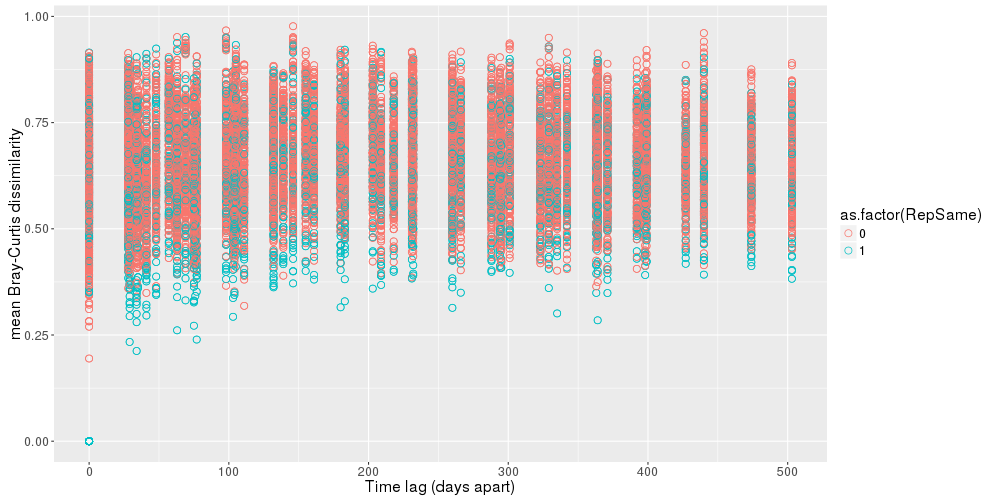

In [25]:
%%R -w 1000 -h 500
p = ggplot(data = test.sep, aes(Day_rel, value, color = as.factor(RepSame))) + geom_point(size = 3, shape = 21) +
    xlab('Time lag (days apart)') + ylab('mean Bray-Curtis dissimilarity') + 
    theme(text = element_text(size = 16)) 
p

### Analyses to do (gstat- just temporal)
* Separate physeq and run distances on each treatment type and block and then plot sum
* Then create variograms - if much different, spatial effects seem to matter; if not, could probably do variogram with all treatments

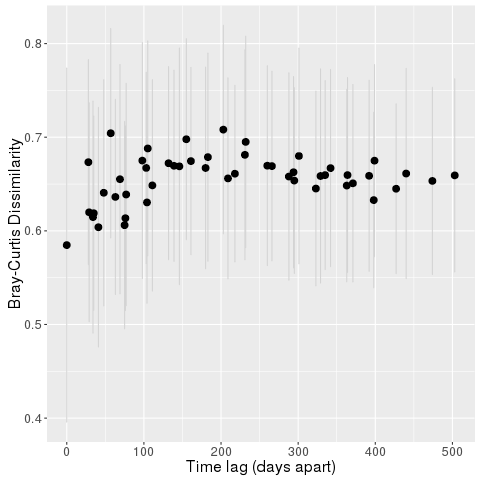

In [26]:
%%R

Test3 = Test2 %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))

limits <- aes(ymax = meanval + sdval, ymin = meanval - sdval)


p = ggplot(data = Test3, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'light grey')+ geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('Bray-Curtis Dissimilarity') + 
    theme(text = element_text(size = 16)) 
p

In [27]:
%%R
physeq.test = sample_data(physeq.Bulk.core)

physeq.test$Sample_Date = as.POSIXct(strptime(physeq.test$Sample_Date , format = "%m/%d/%y"))

physeq.test$day = round(difftime(physeq.test$Sample_Date, min(physeq.test$Sample_Date), units = "days"))

physeq.test$d = as.numeric(physeq.test$day)
time_d = dist(physeq.test$d)

In [28]:
%%R
mantel.rtest(wunif.dist.nopas, time_d, nrepet = 9999)

Monte-Carlo test
Observation: 0.07413229 
Call: mantelnoneuclid(m1 = m1, m2 = m2, nrepet = nrepet)
Based on 9999 replicates
Simulated p-value: 0.0013 


In [29]:
%%R
library(ecodist)
mantel(formula = wunif.dist.nopas ~ time_d, nperm = 10000)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘ecodist’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:vegan’:

    mantel


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:phyloseq’:

    distance


  res = super(Function, self).__call__(*new_args, **new_kwargs)


   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.07413229 0.00220000 0.99790000 0.00230000 0.05500591 0.09668493 


## Semivariogram

In [30]:
%%R
library(geoR)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: --------------------------------------------------------------
 Analysis of Geostatistical Data
 For an Introduction to geoR go to http://www.leg.ufpr.br/geoR
 geoR version 1.7-5.1 (built on 2015-04-15) is now loaded
--------------------------------------------------------------


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [31]:
%%R
head(Test3)

Source: local data frame [6 x 3]

  Day_rel   meanval     sdval
    (dbl)     (dbl)     (dbl)
1       0 0.5848306 0.1891208
2      28 0.6733656 0.1094764
3      29 0.6198392 0.1169004
4      34 0.6147354 0.1239567
5      35 0.6188746 0.1037875
6      41 0.6039108 0.1279668


In [32]:
%%R
v1 = variog(coords = Test3$Day_rel, data = Test3$meanval)


variog: computing omnidirectional variogram
Error in rep(1, nrow(geodata$coords)) : invalid 'times' argument


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in rep(1, nrow(geodata$coords)) : invalid 'times' argument

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘BiocGenerics::Position’ by ‘ggplot2::Position’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packag

## Bray Curtis vs. Soil Temp

In [33]:
%%R
climate = read.csv('../515_806/Chazy-Climate.csv')

In [34]:
%%R
library(lubridate)
climate = filter(climate, !(is.na(Sample_date)))
climate$Month = months(as.Date(climate$Sample_date))
climate$Year = year(climate$Sample_date)
climate$MY = paste(climate$Month, climate$Year, sep = '-')

head(climate, n = 10)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘lubridate’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:plyr’:

    here


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:base’:

    date


  res = super(Function, self).__call__(*new_args, **new_kwargs)


   Airport       Date Fog Rain Snow AvgTemp AvgVisibility MaxTemp MinTemp
1      PBG 1404540000   0    0    0      22            16      82      60
2      PBG 1404626400   0    0    0      22            16      84      59
3      PBG 1404712800   0    1    0      21            14      75      63
4      PBG 1404799200   1    1    0      23             8      84      61
5      PBG 1404885600   0    0    0      22            16      81      63
6      PBG 1404972000   0    0    0      18            16      76      53
7      PBG 1411106400   0    0    0       6            16      55      30
8      PBG 1411192800   0    0    0      12            16      69      36
9      PBG 1411279200   0    1    0      21            15      78      61
10     PBG 1411365600   0    1    0      11            16      63      39
   Precipitation Sample_date     Month Year             MY
1           0.00  2014-07-05      July 2014      July-2014
2           0.00  2014-07-06      July 2014      July-2014
3        

In [35]:
%%R
mean_Temp = climate %>% select(Sample_date, MY, AvgTemp) %>% group_by(MY) %>% mutate(min = dense_rank(AvgTemp)) %>% 
            #filter((min != min(min))) %>% 
            summarise(mean_mean = mean(AvgTemp)) 

mean_Temp %>% as.data.frame

               MY  mean_mean
1      April-2015  8.5000000
2     August-2015 19.3333333
3       July-2014 21.3333333
4       July-2015 21.3333333
5       June-2015 18.0000000
6   November-2014  3.5000000
7   November-2015  0.6666667
8    October-2014  9.3333333
9    October-2015  5.6666667
10 September-2014 12.6666667
11 September-2015 15.6666667


In [36]:
%%R -w 800 -h 500
only_SD = filter(climate, !(Sample_date %in% c ('2014-07-10', '2014-09-24','2014-10-29','2014-11-26','2015-04-30',
                                              '2015-06-17','2015-07-16','2015-08-13','2015-09-23', '2015-10-27',
                                              '2015-11-25')))

physeq.m$MY = paste(physeq.m$Month, physeq.m$Year, sep = '-')
#soil_T = physeq.m %>% select(MY, Soil_Temp) %>% group_by(MY) %>% summarise(meanT = mean(Soil_Temp))
ggplot() +
geom_point(data = physeq.m, aes(MY, Soil_Temp, color = Land_Management), size = 2) +
geom_point(data = mean_Temp, aes(MY, mean_mean), color = 'black', size = 2) + theme(axis.title.x = element_text(face="bold", colour="#990000", size=20),
           axis.text.x  = element_text(angle=90, vjust=0.5, size=16))


Error in paste(physeq.m$Month, physeq.m$Year, sep = "-") : 
  object 'physeq.m' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in paste(physeq.m$Month, physeq.m$Year, sep = "-") : 
  object 'physeq.m' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [37]:
%%R
physeq.test$MY = paste(physeq.test$Month, physeq.test$Year, sep = '-')
df.Temp = left_join(physeq.test, mean_Temp, by = 'MY')

In [38]:
%%R
length(physeq.test$Full.sample)

[1] 176


In [39]:
%%R
df.Temp$AvgTemp = NULL
head(df.Temp)

     Full.sample Fraction PrimerF PrimerR Barcode Rev.index Fwd.index Treatment
1    April.NTR.4       NA  nBITSf   58A2r     155  atagtacc  tagcgagt       NTR
2 Aug.NTR.3.2015       NA  nBITSf   58A2r     129  gatctacg  atcgtacg       NTR
3    April.PTR.3       NA  nBITSf   58A2r     150  acgtgcgc  cgtgagtg       PTR
4   July15.NTH.3       NA  nBITSf   58A2r     184  aacgctga  gacaccgt       NTH
5      Nov.NTR.1       NA  nBITSf   58A2r     125  tctctatg  tcatcgag       NTR
6     June.NTH.2       NA  nBITSf   58A2r     162  gcgtatac  actatctg       NTH
  Day Pool     Experiment Gradient gradient_date fractionation_date BD
1  NA    4 Chazy.ITS.Bulk     <NA>          <NA>               <NA> NA
2  NA    5 Chazy.ITS.Bulk     <NA>          <NA>               <NA> NA
3  NA    4 Chazy.ITS.Bulk     <NA>          <NA>               <NA> NA
4  NA    4 Chazy.ITS.Bulk     <NA>          <NA>               <NA> NA
5  NA    4 Chazy.ITS.Bulk     <NA>          <NA>               <NA> NA
6  NA    4 Cha

In [40]:
%%R
df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))
head(df)

              T1          T2     value
1    April.NTR.4 April.NTR.4 0.0000000
2 Aug.NTR.3.2015 April.NTR.4 0.4997069
3    April.PTR.3 April.NTR.4 0.6171277
4   July15.NTH.3 April.NTR.4 0.5200756
5      Nov.NTR.1 April.NTR.4 0.7084343
6     June.NTH.2 April.NTR.4 0.5763744


In [41]:
%%R
dist.Temp = dist(df.Temp$mean_mean)

In [42]:
%%R
df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))
df.T = melt(as.matrix(dist.Temp, varnames = c('T1', 'T2')))
df.T$tempdist = df.T$value
df.T$T1 = df$T1
df.T$T2 = df$T2
df.T$value = NULL
df.T$Var1 = NULL
df.T$Var2 = NULL

print(head(df))
print(head(df.T))

              T1          T2     value
1    April.NTR.4 April.NTR.4 0.0000000
2 Aug.NTR.3.2015 April.NTR.4 0.4997069
3    April.PTR.3 April.NTR.4 0.6171277
4   July15.NTH.3 April.NTR.4 0.5200756
5      Nov.NTR.1 April.NTR.4 0.7084343
6     June.NTH.2 April.NTR.4 0.5763744
  tempdist             T1          T2
1  0.00000    April.NTR.4 April.NTR.4
2 10.83333 Aug.NTR.3.2015 April.NTR.4
3  0.00000    April.PTR.3 April.NTR.4
4 12.83333   July15.NTH.3 April.NTR.4
5  5.00000      Nov.NTR.1 April.NTR.4
6  9.50000     June.NTH.2 April.NTR.4


In [43]:
%%R
head(df)

              T1          T2     value
1    April.NTR.4 April.NTR.4 0.0000000
2 Aug.NTR.3.2015 April.NTR.4 0.4997069
3    April.PTR.3 April.NTR.4 0.6171277
4   July15.NTH.3 April.NTR.4 0.5200756
5      Nov.NTR.1 April.NTR.4 0.7084343
6     June.NTH.2 April.NTR.4 0.5763744


In [44]:
%%R
df.tot = left_join(df, df.T)
tail(df.tot)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: c("T1", "T2")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


                   T1              T2  value tempdist
30971    July14.PTR.4 Sept.NTH.1.2015 0.9608 5.666667
30972  Aug.PTH.3.2015 Sept.NTH.1.2015 0.8151 3.666667
30973  Aug.PTH.4.2015 Sept.NTH.1.2015 0.8358 3.666667
30974 Sept.NTR.2.2015 Sept.NTH.1.2015 0.9138 0.000000
30975  Aug.PTH.2.2015 Sept.NTH.1.2015 0.7622 3.666667
30976 Sept.NTH.1.2015 Sept.NTH.1.2015 0.0000 0.000000


In [45]:
%%R
head(df.tot, n = 20)
df.tot.sep = df.tot %>% tidyr::separate(T1, c("Month_T1", "Treatment_T1", "Rep_T1"))
df.tot.sep = df.tot.sep %>% tidyr::separate(T2, c("Month_T2", "Treatment_T2", "Rep_T2"))

head(df.tot.sep)

  Month_T1 Treatment_T1 Rep_T1 Month_T2 Treatment_T2 Rep_T2     value tempdist
1    April          NTR      4    April          NTR      4 0.0000000  0.00000
2      Aug          NTR      3    April          NTR      4 0.4997069 10.83333
3    April          PTR      3    April          NTR      4 0.6171277  0.00000
4   July15          NTH      3    April          NTR      4 0.5200756 12.83333
5      Nov          NTR      1    April          NTR      4 0.7084343  5.00000
6     June          NTH      2    April          NTR      4 0.5763744  9.50000


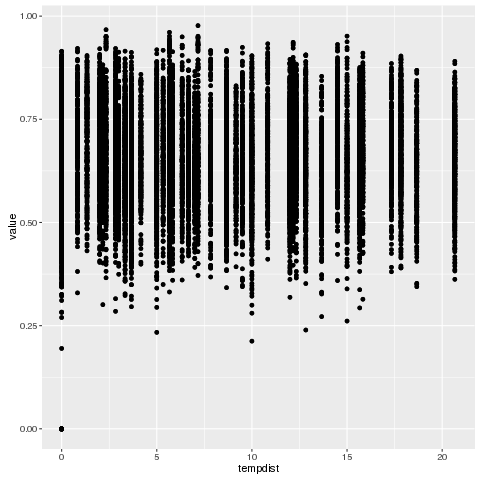

In [46]:
%%R
ggplot(data = df.tot, aes(x = tempdist, y = value)) + geom_point()

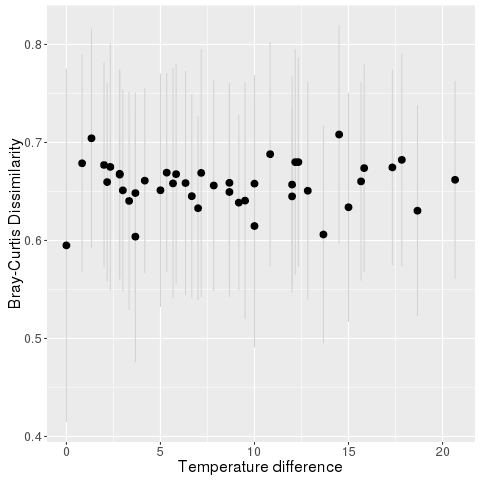

In [47]:
 %%R
mean.tempdist = df.tot %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'light grey')+ 
        geom_point(size = 3) +
    xlab('Temperature difference') + ylab('Bray-Curtis Dissimilarity') + 
    theme(text = element_text(size = 16)) 
p

In [48]:
%%R
library(ecodist)
mantel(formula = wunif.dist.nopas ~ dist.Temp, nperm = 10000)

   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.04071949 0.03380000 0.96630000 0.06300000 0.02576789 0.05677943 


## Split into Treatment

In [49]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$Till%>% unique
u.lm

[1] N P
Levels: N P


In [50]:
%%R
physeq.Treat.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Till == d)
    physeq.Treat.l[[d]] = tmp
    print(d)
    physeq.Treat.l[[d]] %>% print
    }

[1] "N"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 88 samples ]
sample_data() Sample Data:       [ 88 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "P"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 88 samples ]
sample_data() Sample Data:       [ 88 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [51]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.treat.l = lapply(physeq.Treat.l, calc.MH.dist, cores=nprocs)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Processing sample...

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [52]:
%%R
#Sample metadata for split physeq objects
physeq.Treat.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Till == d)
    physeq.Treat.meta[[d]] = sample_data(tmp)
    }


In [53]:
%%R
#treatments = c('NTR', 'PTR','NTH', 'PTH')
treatments = c('N', 'P')
str(treatments)

 chr [1:2] "N" "P"


In [54]:
%%R

join_temp = function(treatment, dist.mat, metadata, tempdata){
    
    m = data.frame(metadata[[treatment]])
    tempdata = as.data.frame(tempdata)
    dist = dist.mat[[treatment]]
    
    #creating matrix of Morisita-horn distances
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    
    #adding metadata to temperature phlyoseq object
    m$MY = paste(m$Month, m$Year, sep = '-')
    df.Temp = left_join(m, tempdata, by = 'MY')
    
    #Creating temperature distance matrix
    dist.Temp = dist(df.Temp$mean_mean)
    df.T = melt(as.matrix(dist.Temp, varnames = c('T1', 'T2')))
    
    #Adding sample information
    df.T$tempdist = df.T$value
    df.T$T1 = df.melt$T1
    df.T$T2 = df.melt$T2

    #Removing other variables
    df.T$value = NULL
    df.T$Var1 = NULL
    df.T$Var2 = NULL
    
    
    df.tot = left_join(df.melt, df.T)
    df.tot$Treatment = treatment

  
    return(df.tot)
    
    
}


temp.data = lapply(treatments, join_temp, metadata = physeq.Treat.meta, dist.mat = MH.dist.treat.l, tempdata = mean_Temp)

In [55]:
%%R
str(temp.data)

List of 2
 $ :'data.frame':	7744 obs. of  5 variables:
  ..$ T1       : Factor w/ 88 levels "April.NTR.4",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 88 levels "April.NTR.4",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ value    : num [1:7744] 0 0.5 0.52 0.708 0.576 ...
  ..$ tempdist : num [1:7744] 0 10.8 12.8 5 9.5 ...
  ..$ Treatment: chr [1:7744] "N" "N" "N" "N" ...
 $ :'data.frame':	7744 obs. of  5 variables:
  ..$ T1       : Factor w/ 88 levels "April.PTR.3",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 88 levels "April.PTR.3",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ value    : num [1:7744] 0 0.677 0.361 0.574 0.574 ...
  ..$ tempdist : num [1:7744] 0 4.17 9.5 12.83 4.17 ...
  ..$ Treatment: chr [1:7744] "P" "P" "P" "P" ...


In [56]:
%%R

##Need to figure out how to include multiple lists in the function itself...
join_temp = function(metadata, tempdata){
    
    #adding metadata to temperature phlyoseq object
    metadata$MY = paste(metadata$Month, metadata$Year, sep = '-')
    df.Temp = left_join(metadata, tempdata, by = 'MY')
    
    #Creating temperature distance matrix
    dist.Temp = dist(df.Temp$mean_mean)
   
    return(dist.Temp)
    
    
}


temp.dist = lapply(physeq.Treat.meta, join_temp, tempdata = mean_Temp)

In [57]:
%%R

plot_by_treatment = function(df.tempdist) {
    
    treatment = unique(df.tempdist$Treatment)
    
    print(length(df.tempdist$tempdist))

    df.tempdist$tempdist = round(df.tempdist$tempdist, digits = 4)
    
    mean.tempdist = df.tempdist %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))
p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Temperature difference') + ylab('Bray-Curtis Dissimilarity') + 
    theme(text = element_text(size = 16)) + ggtitle(treatment)

return(p) 
    
}

plots = lapply(temp.data, plot_by_treatment)

[1] 7744
[1] 7744


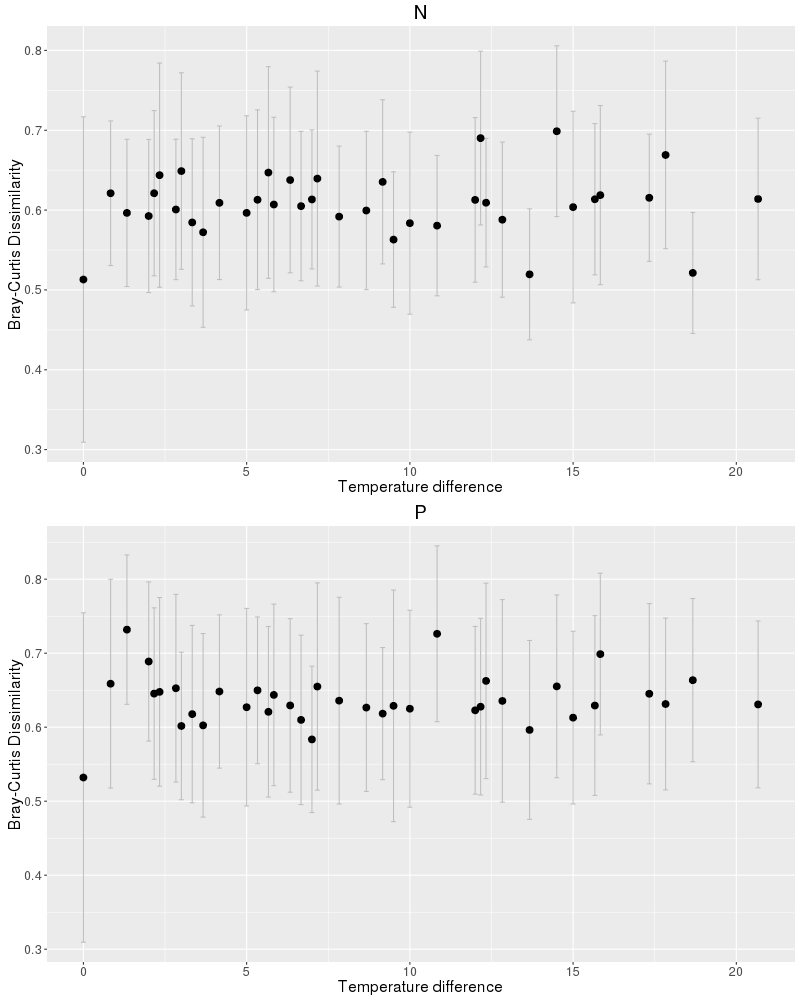

In [58]:
%%R -w 800 -h 1000
do.call(grid.arrange, c(plots,list(ncol=1)))

In [59]:
%%R
mantel.Temp = function(treatment, df.temp, df.dist) {
    
    df.t = df.temp[[treatment]]
    df.d = df.dist[[treatment]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.temp = lapply(treatments, df.temp = temp.dist, df.dist = MH.dist.treat.l, mantel.Temp)

In [60]:
%%R
head(m.temp)

[[1]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.06543356 0.03550000 0.96460000 0.05320000 0.03624279 0.09558264 

[[2]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
0.031634595 0.162900000 0.837200000 0.334600000 0.008755305 0.054076873 



## Separation by Replicate - temp vs phylogenetic distance

In [61]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$Replicate %>% unique
u.lm

[1] 4 3 1 2


In [62]:
%%R
physeq.Rep.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.l[[d]] = tmp
    print(d)
    physeq.Rep.l[[d]] %>% print
    }

[1] "4"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "3"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "1"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "2"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [63]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.rep.l = lapply(physeq.Rep.l, calc.MH.dist, cores=nprocs)

In [64]:
%%R
#Sample metadata for split physeq objects
physeq.Rep.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.meta[[d]] = sample_data(tmp)
    }


In [65]:
%%R
replicates = c(4, 3, 1, 2)
str(replicates)

 num [1:4] 4 3 1 2


In [66]:
%%R

join_rep = function(replicate, dist.mat, metadata, tempdata){
    
    m = data.frame(metadata[[as.character(replicate)]])
    tempdata = as.data.frame(tempdata)
    dist = dist.mat[[as.character(replicate)]]
    #creating matrix of Morisita-horn distances
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    
    #adding metadata to temperature phlyoseq object
    m$MY = paste(m$Month, m$Year, sep = '-')
    df.Temp = left_join(m, tempdata, by = 'MY')
    
    #Creating temperature distance matrix
    dist.Temp = dist(df.Temp$mean_mean)
    df.T = melt(as.matrix(dist.Temp, varnames = c('T1', 'T2')))
    
    #Adding sample information
    df.T$tempdist = df.T$value
    df.T$T1 = df.melt$T1
    df.T$T2 = df.melt$T2

    #Removing other variables
    df.T$value = NULL
    df.T$Var1 = NULL
    df.T$Var2 = NULL
    
    
    df.tot = left_join(df.melt, df.T)
    df.tot$Replicate = replicate

  
    return(df.tot)
    
    
}


temp.data = lapply(replicates, join_rep, metadata = physeq.Rep.meta, dist.mat = MH.dist.rep.l, tempdata = mean_Temp)

In [67]:
%%R

##Need to figure out how to include multiple lists in the function itself...
join_rep = function(metadata, tempdata){
    
    #adding metadata to temperature phlyoseq object
    metadata$MY = paste(metadata$Month, metadata$Year, sep = '-')
    df.Temp = left_join(metadata, tempdata, by = 'MY')
    #Creating temperature distance matrix
    dist.Temp = dist(df.Temp$mean_mean)
   
    return(dist.Temp)
    
    
}


temp.dist = lapply(physeq.Rep.meta, join_rep, tempdata = mean_Temp)

In [68]:
%%R
str(temp.dist)

List of 4
 $ 4:Class 'dist'  atomic [1:946] 4.17 12.83 7.83 12.83 0 ...
  .. ..- attr(*, "Size")= int 44
  .. ..- attr(*, "Diag")= logi FALSE
  .. ..- attr(*, "Upper")= logi FALSE
  .. ..- attr(*, "method")= chr "euclidean"
  .. ..- attr(*, "call")= language dist(x = df.Temp$mean_mean)
 $ 3:Class 'dist'  atomic [1:946] 10.83 2 10.83 1.33 6.67 ...
  .. ..- attr(*, "Size")= int 44
  .. ..- attr(*, "Diag")= logi FALSE
  .. ..- attr(*, "Upper")= logi FALSE
  .. ..- attr(*, "method")= chr "euclidean"
  .. ..- attr(*, "call")= language dist(x = df.Temp$mean_mean)
 $ 1:Class 'dist'  atomic [1:946] 2.83 17.83 5 14.5 5.83 ...
  .. ..- attr(*, "Size")= int 44
  .. ..- attr(*, "Diag")= logi FALSE
  .. ..- attr(*, "Upper")= logi FALSE
  .. ..- attr(*, "method")= chr "euclidean"
  .. ..- attr(*, "call")= language dist(x = df.Temp$mean_mean)
 $ 2:Class 'dist'  atomic [1:946] 9.5 12.3 12.3 0 12.3 ...
  .. ..- attr(*, "Size")= int 44
  .. ..- attr(*, "Diag")= logi FALSE
  .. ..- attr(*, "Upper")= logi

In [69]:
%%R

plot_by_replicate = function(df.tempdist) {
    
    replicate = unique(df.tempdist$Replicate)

    df.tempdist$tempdist = round(df.tempdist$tempdist, digits = 3)
    
    mean.tempdist = df.tempdist %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

    p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Temperature difference') + ylab('Bray-Curtis Dissimilarity') + 
    theme(text = element_text(size = 16)) + ggtitle(replicate)

return(p) 
    
}

plots = lapply(temp.data, plot_by_replicate)

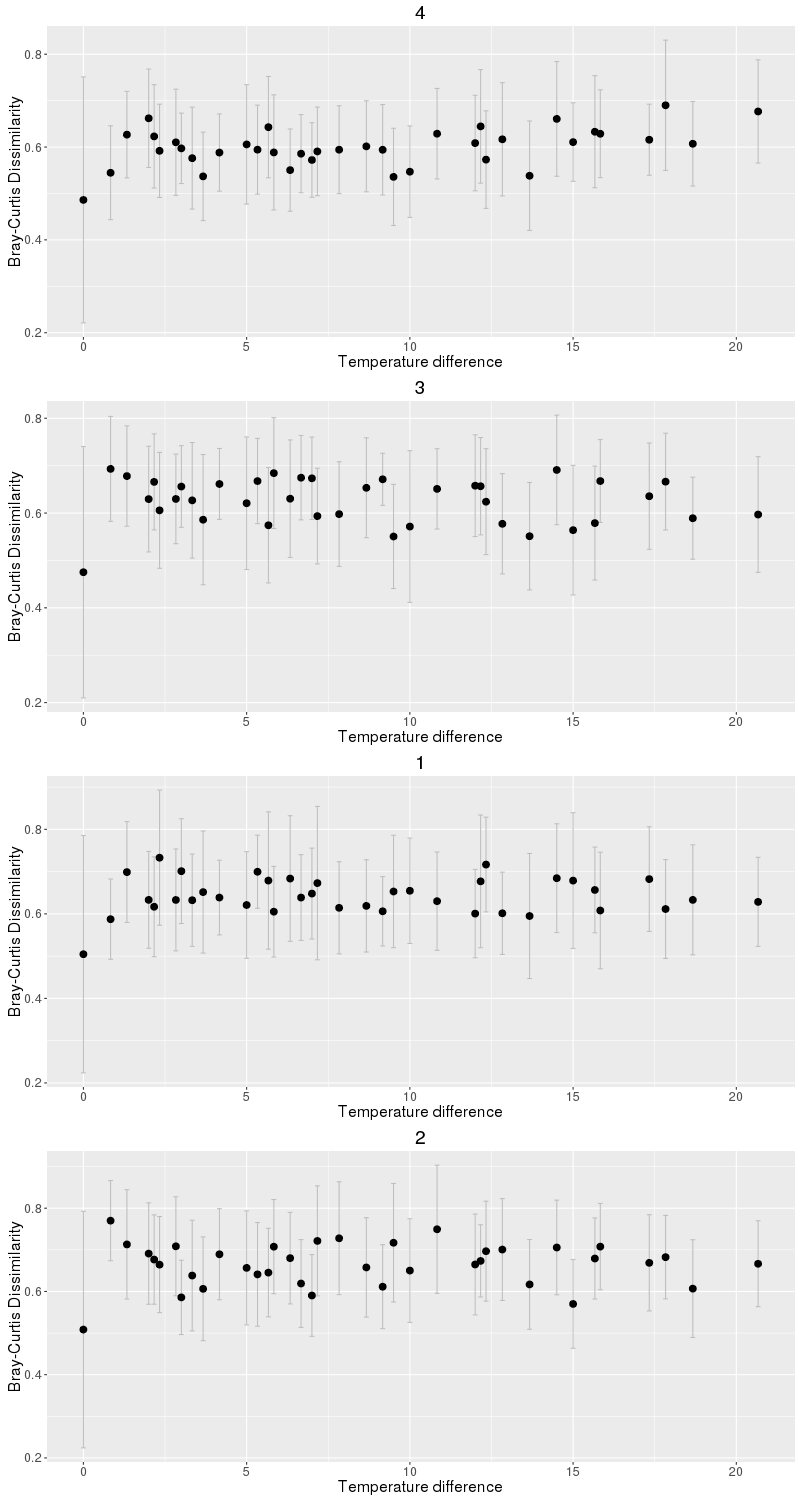

In [70]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))

In [71]:
%%R
mantel.Temp = function(replicate, df.temp, df.dist) {
    
    df.t = df.temp[[as.character(replicate)]]
    df.d = df.dist[[replicate]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.temp = lapply(replicates, df.temp = temp.dist, df.dist = MH.dist.rep.l, mantel.Temp)

In [72]:
%%R
#Results - replicates 4, 3, 1, 2
m.temp

[[1]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
 0.02298989  0.31400000  0.68610000  0.66160000 -0.01220161  0.05898601 

[[2]]
     mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
 0.036000939  0.221700000  0.778400000  0.459300000 -0.009374362  0.089339666 

[[3]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
 0.01303124  0.37240000  0.62770000  0.78920000 -0.01669333  0.04362886 

[[4]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
-0.04251876  0.83030000  0.16980000  0.33910000 -0.07367606 -0.01797081 



## Phylogenetic distance vs time

In [73]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$Land_Management %>% unique
u.lm

[1] NTR PTR NTH PTH
Levels: NTH NTR PTH PTR


In [74]:
%%R
physeq.Treat.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Land_Management == d)
    physeq.Treat.l[[d]] = tmp
    print(d)
    physeq.Treat.l[[d]] %>% print
    }

[1] "NTR"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "PTR"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "NTH"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "PTH"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [75]:
%%R
#Sample metadata for split physeq objects
physeq.Treat.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Land_Management == d)
    physeq.Treat.meta[[d]] = sample_data(tmp)
    }


In [76]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.treat.l = lapply(physeq.Treat.l, calc.MH.dist, cores=nprocs)

In [77]:
%%R
treatments = c('NTR', 'PTR', 'NTH', 'PTH')
str(treatments)

 chr [1:4] "NTR" "PTR" "NTH" "PTH"


In [78]:
%%R
physeq.m = physeq.Bulk.core %>% sample_data

join_temp = function(treatment, dist.mat, metadata){
    
    #m = data.frame(metadata[[treatment]])
    dist = dist.mat[[treatment]]

    #dataframe of distances 
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    

    
    physeq.test = plyr::rename(metadata, c("Full.sample"="T1", "Sample_Date"="SD_T1"))
    Test = full_join(df.melt, physeq.test, by = 'T1')
    physeq.test2 = plyr::rename(physeq.test, c("T1"="T2", "SD_T1"="SD_T2"))
    Test2 = full_join(Test, physeq.test2, by = 'T2')
    
    #Creation of relative days distance matrix
    Test2 = Test2 %>% select(T1, T2, value, SD_T1, SD_T2)
    Test2$SD_T1 = as.POSIXct(strptime(Test2$SD_T1, format = "%m/%d/%y"))
    Test2$SD_T2 = as.POSIXct(strptime(Test2$SD_T2, format = "%m/%d/%y"))
    Test2$Day = abs(round(difftime(Test2$SD_T1, Test2$SD_T2, 
         units = "days")))

    Test2$Day_rel = as.numeric(Test2$Day)
    Test2$Treatment = treatment
  
    return(Test2)
    
    
}


time.data = lapply(treatments, join_temp, metadata = physeq.m, dist.mat = MH.dist.treat.l)

In [79]:
%%R

plot_by_treatment = function(df.timedist) {
    
   treatment = unique(df.timedist$Treatment)
    
   mean.timedist = df.timedist %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))

p = ggplot(data = mean.timedist, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('Morisita-horn index') + 
    theme(text = element_text(size = 16)) + ggtitle(treatment)

return(p) 
    
}

plots = lapply(time.data, plot_by_treatment)

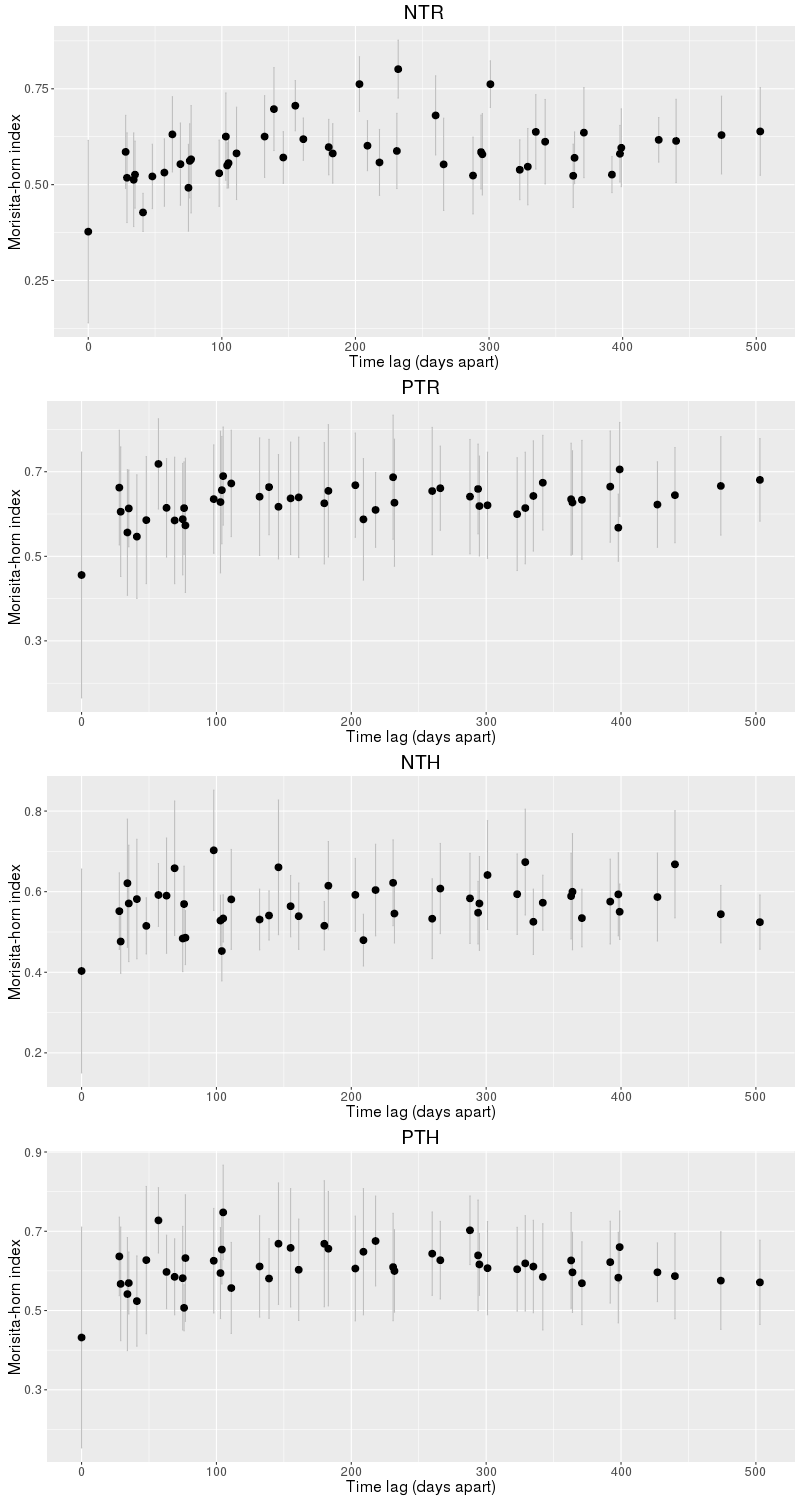

In [80]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))

In [81]:
%%R
make_time_dist = function(physeq.obj) {
    
    physeq.test = sample_data(physeq.obj)

    physeq.test$Sample_Date = as.POSIXct(strptime(physeq.test$Sample_Date , format = "%m/%d/%y"))

    physeq.test$day = round(difftime(physeq.test$Sample_Date, min(physeq.test$Sample_Date), units = "days"))

    physeq.test$d = as.numeric(physeq.test$day)
    
    time_d = dist(physeq.test$d)
    
    return(time_d)
    
}

time_dist = lapply(physeq.Treat.l, make_time_dist)


In [82]:
%%R
mantel.Time = function(treatment, df.time, df.dist) {
    
    df.t = df.time[[treatment]]
    df.d = df.dist[[treatment]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.time = lapply(treatments, df.time = time_dist, df.dist = MH.dist.treat.l, mantel.Time)

In [83]:
%%R
#NTR, PTR, NTH, PTH - order of results
m.time

[[1]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.2116215  0.0005000  0.9996000  0.0005000  0.1579602  0.2806818 

[[2]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.08357097 0.06210000 0.93800000 0.10280000 0.05166019 0.12807374 

[[3]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.10330507 0.04890000 0.95120000 0.07330000 0.06344394 0.17155126 

[[4]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
0.029642033 0.280000000 0.720100000 0.591800000 0.002457781 0.079200680 



## Time vs phylogenetic distance, by replicate

In [84]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$Replicate %>% unique
u.lm

[1] 4 3 1 2


In [85]:
%%R
physeq.Rep.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.l[[d]] = tmp
    print(d)
    physeq.Rep.l[[d]] %>% print
    }

[1] "4"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "3"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "1"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "2"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [86]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.rep.l = lapply(physeq.Rep.l, calc.MH.dist, cores=nprocs)

In [87]:
%%R
#Sample metadata for split physeq objects
physeq.Rep.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.meta[[d]] = sample_data(tmp)
    }


In [88]:
%%R
replicates = c(4, 3, 1, 2)
str(replicates)

 num [1:4] 4 3 1 2


In [89]:
%%R
physeq.m = physeq.Bulk.core %>% sample_data

join_temp = function(replicate, dist.mat, metadata){
    
    #m = data.frame(metadata[[treatment]])
    dist = dist.mat[[replicate]]

    #dataframe of distances 
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    

    
    physeq.test = plyr::rename(metadata, c("Full.sample"="T1", "Sample_Date"="SD_T1"))
    Test = full_join(df.melt, physeq.test, by = 'T1')
    physeq.test2 = plyr::rename(physeq.test, c("T1"="T2", "SD_T1"="SD_T2"))
    Test2 = full_join(Test, physeq.test2, by = 'T2')
    
    #Creation of relative days distance matrix
    Test2 = Test2 %>% select(T1, T2, value, SD_T1, SD_T2)
    Test2$SD_T1 = as.POSIXct(strptime(Test2$SD_T1, format = "%m/%d/%y"))
    Test2$SD_T2 = as.POSIXct(strptime(Test2$SD_T2, format = "%m/%d/%y"))
    Test2$Day = abs(round(difftime(Test2$SD_T1, Test2$SD_T2, 
         units = "days")))

    Test2$Day_rel = as.numeric(Test2$Day)
    Test2$Replicate = replicate
  
    return(Test2)
    
    
}


time.data = lapply(replicates, join_temp, metadata = physeq.m, dist.mat = MH.dist.rep.l)

In [90]:
%%R

plot_by_replicate = function(df.timedist) {
    
   replicate = unique(df.timedist$Replicate)
    
   mean.timedist = df.timedist %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))

p = ggplot(data = mean.timedist, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('Morisita-horn index') + 
    theme(text = element_text(size = 16)) + ggtitle(replicate)

return(p) 
    
}

plots = lapply(time.data, plot_by_replicate)

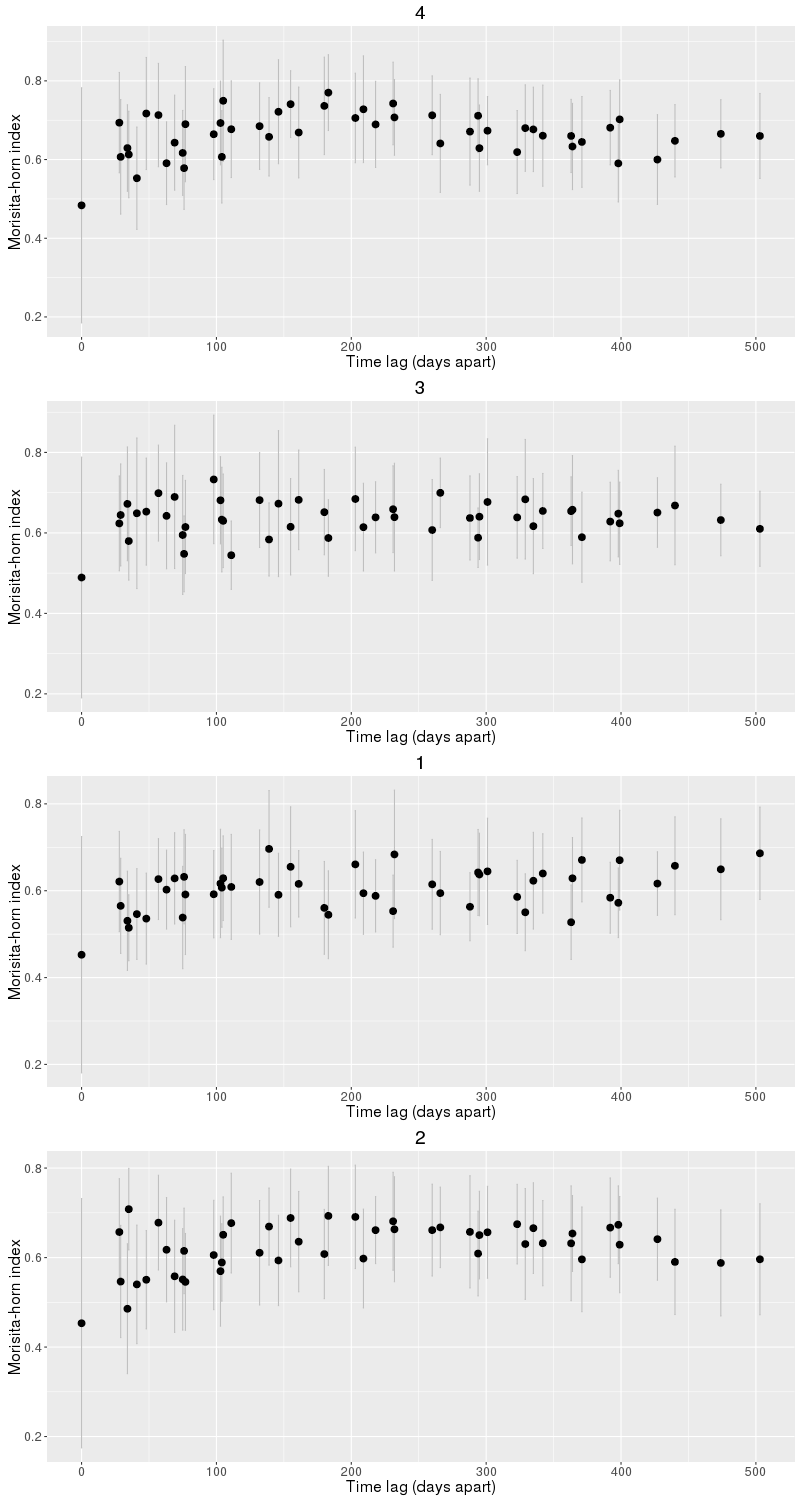

In [91]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))

In [92]:
%%R
make_time_dist = function(physeq.obj) {
    
    physeq.test = sample_data(physeq.obj)

    physeq.test$Sample_Date = as.POSIXct(strptime(physeq.test$Sample_Date , format = "%m/%d/%y"))

    physeq.test$day = round(difftime(physeq.test$Sample_Date, min(physeq.test$Sample_Date), units = "days"))

    physeq.test$d = as.numeric(physeq.test$day)
    
    time_d = dist(physeq.test$d)
    
    return(time_d)
    
}

time_dist = lapply(physeq.Rep.l, make_time_dist)


In [93]:
%%R
mantel.Time = function(replicate, df.time, df.dist) {
    
    df.t = df.time[[replicate]]
    df.d = df.dist[[replicate]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.time = lapply(replicates, df.time = time_dist, df.dist = MH.dist.rep.l, mantel.Time)

In [94]:
%%R
# Order: Replicates 4, 3, 1, 2
m.time

[[1]]
     mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
 0.031283738  0.264100000  0.736000000  0.559400000 -0.005543668  0.078386710 

[[2]]
     mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
-0.009661685  0.552500000  0.447600000  0.847500000 -0.042219101  0.039080704 

[[3]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.12413044 0.01230000 0.98780000 0.01390000 0.07176216 0.16949150 

[[4]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.12435737 0.00890000 0.99120000 0.00960000 0.08745005 0.17355170 



## By particular class

In [95]:
%%R

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE)
#physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk.core = prune_samples(physeq.Bulk.m$Land_Management != "PAS", physeq.Bulk)

physeq.Bulk.m = physeq.Bulk.core %>% sample_data
    

physeq.Bulk.core = physeq.Bulk.core %>% transform_sample_counts(function(x) x/sum(x)) 

physeq.Bulk.m = physeq.Bulk.core %>% sample_data

#print(physeq.Bulk.Sparsity)
print(physeq.Bulk.core)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [96]:
%%R
physeq.test = subset_taxa(physeq.Bulk.core, Rank1 == 'k__Fungi' & !(is.na(Rank3)))
physeq.test

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2073 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2073 taxa by 7 taxonomic ranks ]


In [97]:
%%R
tax = as.data.frame(tax_table(physeq.test))
Class = unique(tax$Rank3)
Class = list(head(Class, n = 5))
Class

[[1]]
[1] c__Dothideomycetes c__unidentified    c__Agaricomycetes  c__Incertae sedis 
[5] c__Sordariomycetes
26 Levels: c__Agaricomycetes c__Agaricostilbomycetes ... c__Wallemiomycetes



In [98]:
%%R
physeq.class.l = list()

for (d in as.character(Class)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_taxa(physeq.test, Rank3 == d) 
    physeq.class.l[[d]] = tmp
    print(d)
    physeq.class.l[[d]] %>% print
    }


Error in `rownames<-`(`*tmp*`, value = c("sp1", "sp0")) : 
  length of 'dimnames' [1] not equal to array extent


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in `rownames<-`(`*tmp*`, value = c("sp1", "sp0")) : 
  length of 'dimnames' [1] not equal to array extent

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 41 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [99]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.class.l = lapply(physeq.class.l, calc.MH.dist, cores=nprocs)

In [100]:
%%R
#Sample metadata for split physeq objects
physeq.C.meta = list()

for (d in as.character(Class)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_taxa(physeq.test, Rank3 == d)
    physeq.C.meta[[d]] = sample_data(tmp)
    }



Error in `rownames<-`(`*tmp*`, value = c("sp1", "sp0")) : 
  length of 'dimnames' [1] not equal to array extent


In [101]:
%%R
physeq.m = physeq.test %>% sample_data

join_temp = function(Class, dist.mat, metadata){

    dist = dist.mat[[Class]]
    #return(dist)
    #dataframe of distances 
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    

    
    physeq.test = plyr::rename(metadata, c("Full.sample"="T1", "Sample_Date"="SD_T1"))
    Test = full_join(df.melt, physeq.test, by = 'T1')
    physeq.test2 = plyr::rename(physeq.test, c("T1"="T2", "SD_T1"="SD_T2"))
    Test2 = full_join(Test, physeq.test2, by = 'T2')
    
    #Creation of relative days distance matrix
    Test2 = Test2 %>% select(T1, T2, value, SD_T1, SD_T2)
    Test2$SD_T1 = as.POSIXct(strptime(Test2$SD_T1, format = "%m/%d/%y"))
    Test2$SD_T2 = as.POSIXct(strptime(Test2$SD_T2, format = "%m/%d/%y"))
    Test2$Day = abs(round(difftime(Test2$SD_T1, Test2$SD_T2, 
         units = "days")))

    Test2$Day_rel = as.numeric(Test2$Day)
    Test2$Class = Class
  
    return(Test2)
    
    
}


time.data = lapply(Class, join_temp, metadata = physeq.m, dist.mat = MH.dist.class.l)


Error in dist.mat[[Class]] : no such index at level 1


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in dist.mat[[Class]] : no such index at level 1

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [102]:
%%R

plot_by_class = function(df.timedist) {
    
   class = unique(df.timedist$Class)
    
   mean.timedist = df.timedist %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))
    return(mean.timedist)
p = ggplot(data = mean.timedist, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('Morisita-horn index') + 
    theme(text = element_text(size = 16)) + ggtitle(replicate)

return(p) 
    
}

plots = lapply(time.data, plot_by_class)

In [103]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))


Error in gList(list(Day_rel = c(0, 28, 29, 34, 35, 41, 48, 57, 63, 69,  : 
  only 'grobs' allowed in "gList"


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in gList(list(Day_rel = c(0, 28, 29, 34, 35, 41, 48, 57, 63, 69,  : 
  only 'grobs' allowed in "gList"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


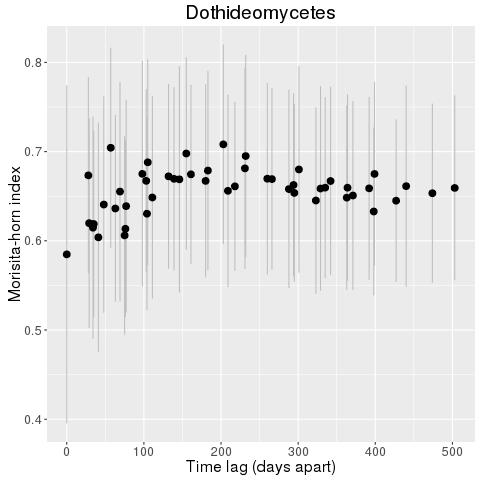

In [104]:
%%R

mean.timedist = Test2 %>% group_by(Day_rel) %>% summarise(meanval = mean(value), sdval = sd(value))

limits <- aes(ymax = meanval + sdval, ymin = meanval - sdval)


p = ggplot(data = mean.timedist, aes(Day_rel, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Time lag (days apart)') + ylab('Morisita-horn index') + 
    theme(text = element_text(size = 16)) + ggtitle("Dothideomycetes")

p

In [105]:
%%R
 physeq.mtest = sample_data(physeq.test)

physeq.mtest$Sample_Date = as.POSIXct(strptime(physeq.mtest$Sample_Date , format = "%m/%d/%y"))

physeq.mtest$day = round(difftime(physeq.mtest$Sample_Date, min(physeq.mtest$Sample_Date), units = "days"))

physeq.mtest$d = as.numeric(physeq.mtest$day)
    
time_d = dist(physeq.mtest$d)
    

    


In [106]:
%%R
library(ecodist)
mantel(formula = MH.dist ~ time_d, nperm = 10000)


Error in eval(expr, envir, enclos) : object 'MH.dist' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'MH.dist' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
